# Steven Rae - Machine Learning Capstone Project - Step 3

## Using Support Vector Machines Classification Technique

**Question to be Answered:** Is there a way to predict if a person is a musician(or has in interest in music) from info in their profile (specifically levels of smoking and drinking)

Define inputs and load the OKCupid data into a pandas dataframe:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

okcupidDF = pd.read_csv("profiles.csv")

String together all the essay questions and search for the word 'music'. Basic assumption is that if they mention music anywhere in the essays they are either a musician or have an interest in music.


In [2]:
essay_cols = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]


# Removing the NaNs
all_essays = okcupidDF[essay_cols].replace(np.nan, '', regex=True)
# Combining the essays
all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)


okcupidDF['comb_essays'] = all_essays

# print(okcupidDF['comb_essays'].head())

# add label column to dataframe to identify music interest
okcupidDF['is_music'] = np.where(okcupidDF['comb_essays'].str.contains('music'), 1, 0)

Need to address the okcupidDF columns 'smokes' and 'drinks'.
okcupidDF['is_music'] does not have any NaNs, but smokes and drinks do.
Remove NaNs from smokes and drinks

In [3]:
okcupidDF = okcupidDF.dropna(subset= ['drinks', 'smokes'])

In [4]:
drink_mapping = {'not at all': 1, 'rarely': 2, 'socially': 3, 'often': 4, 'very often': 5, 'desperately': 6}

# add new drinks mapping to dataframe
okcupidDF['drinks_code'] = okcupidDF.drinks.map(drink_mapping)

smoke_mapping = {'no': 1, 'when drinking': 2, 'sometimes': 3, 'yes': 4, 'trying to quit': 5}

# add new smokes mapping to dataframe
okcupidDF['smokes_code'] = okcupidDF.smokes.map(smoke_mapping)

Create a dataframe that's a subset of the okcupidDF. This new dataframe will be the input to the classification model:

In [5]:
feature_data = okcupidDF[['drinks_code', 'smokes_code', 'is_music']]

Mappings for drinks and smokes are not on the same scale. Need to normalize our classification model dataset:

In [6]:
x = feature_data.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)

print(feature_data.head())

   drinks_code  smokes_code  is_music
0          0.4          0.5       1.0
1          0.6          0.0       1.0
2          0.4          0.0       1.0
3          0.4          0.0       0.0
4          0.4          0.0       1.0


/Users/steverae/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Run a scatterplot to visualize the data:

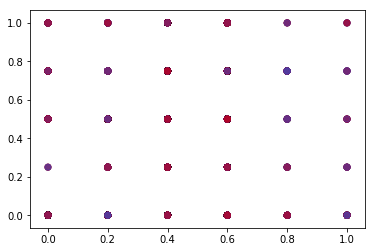

In [7]:
fig, ax = plt.subplots()

plt.scatter(feature_data['drinks_code'],
            feature_data['smokes_code'],
            c = feature_data['is_music'],
            cmap = plt.cm.coolwarm,
            alpha = 0.25)

plt.show()

Hmmm..... The data seems to show that musical interest is spread all through the smokes/drinks spectrum. Not seeing any obvious clusters of data. Still... soldiering on. Create training and validation sets, validation set should be 25% of data by default:

In [8]:
training_set, validation_set = train_test_split(feature_data, random_state = 1)

Run a series of SVC classifier setups to see if we can find a best fit. C is margin size, if C is large, it has a hard margin and won't allow for many mis-classifications. If C is too large, then model runs the risk of overfitting, relying too heavily on the training data. As for gamma, higher gamma value puts more emphasis on the training data:

In [9]:
for gamma in range(1, 5):
    for C in range(1, 5):
        classifier = SVC(kernel='rbf', gamma = gamma, C = C)
        classifier.fit(training_set[['drinks_code', 'smokes_code']], training_set['is_music'])

        score = classifier.score(validation_set[['drinks_code', 'smokes_code']], validation_set['is_music'])
        score_list = [gamma, C, score]
        print(score_list)

[1, 1, 0.6845180136319376]
[1, 2, 0.6845180136319376]
[1, 3, 0.6845180136319376]
[1, 4, 0.6845180136319376]
[2, 1, 0.6845180136319376]
[2, 2, 0.6845180136319376]
[2, 3, 0.6845180136319376]
[2, 4, 0.6845180136319376]
[3, 1, 0.6845180136319376]
[3, 2, 0.6845180136319376]
[3, 3, 0.6845180136319376]
[3, 4, 0.6845180136319376]
[4, 1, 0.6845180136319376]
[4, 2, 0.6845180136319376]
[4, 3, 0.6845180136319376]
[4, 4, 0.6845180136319376]


It looks like regardless of which values of gamma and C are used, they don't have much effect on the score. Assuming this has everything to do with the virtual non-clustering of the data. Starting to look like a very dumb analysis to try and make. Soldiering on anyway. Picking a gamma of 0.8 and a C of 1. Fitting the training set and scoring both training and validation:

In [11]:
gamma = 0.8
C = 1
classifier = SVC(kernel='rbf', gamma = gamma, C = C)
classifier.fit(training_set[['drinks_code', 'smokes_code']], training_set['is_music'])
validation_score = classifier.score(validation_set[['drinks_code', 'smokes_code']], validation_set['is_music'])
validation_score_list = [gamma, C, validation_score]
print(validation_score_list)
validation_prediction = classifier.predict(validation_set[['drinks_code', 'smokes_code']])

training_score = classifier.score(training_set[['drinks_code', 'smokes_code']], training_set['is_music'])
training_score_list = [gamma, C, training_score]
print(training_score_list)
training_prediction = classifier.predict(training_set[['drinks_code', 'smokes_code']])

[0.8, 1, 0.6845180136319376]
[0.8, 1, 0.6842276097975082]


Not seeing a significant difference between training and validation scores. The results do not appear to be overfitted to the training data.

In [14]:
print(classification_report(validation_set['is_music'], validation_prediction))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      4212
         1.0       0.68      1.00      0.81      9139

   micro avg       0.68      0.68      0.68     13351
   macro avg       0.34      0.50      0.41     13351
weighted avg       0.47      0.68      0.56     13351



In [15]:
print(classification_report(training_set['is_music'], training_prediction))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     12647
         1.0       0.68      1.00      0.81     27404

   micro avg       0.68      0.68      0.68     40051
   macro avg       0.34      0.50      0.41     40051
weighted avg       0.47      0.68      0.56     40051



## Step 3 Conclusions

Conclusions here are very similar to Step 4. The value counts for 'is_music' suggest about 2/3 of the entire dataset identifies with music to some degree. So the dataset is somewhat imbalanced in terms of musical interest. It would have been great of the dataset asked a specific questions like 'are you into music?' and/or 'are you a musician?'. An additional essay question asking the clients to detail their interest/involvement with music would have been very helpful.

All the messures (Accuracy, preceicion, recall and F1) are virtually the same for both the training and validation sets, which suggests overfitting the training data is not an issue here. Accuracy is an ok measure here as the dataset is not overly imbalanced. Precision in choosing 'is music' mirrors the Accuracy measures but is not so good at truely picking people with no musical interest. Recall and F1 suggest the model is very good at identifiying musical people. while not so good at identifiying non-musical people. 

Ideally I'd like to add some extra questions directly about music, and get a more even representation of musical and non-musical people/classes. Adding dependent variables directly related to identifying musical persuits would also be helpful in determining a good predictive model.

It's somewhat eerie to me that the outcome is so similar to Step 4, which used more dependent variables and a different classification technique. It suggests that the current set of dependent variables don't have much effect on the prediction. There doesn't seem to be much clustering of data for this, and the predictions are more to do with the slightly imbalanced data classes. 